## Rerun heritability estimation

(2023/08/31)

* Genome wide heritability estimation might not be suitable when comparing prediction model performance (R2). Try to redo heritability estimation using SNPs with GWAS pval<1e-3 (the same threshold as in prediction model training)


* The Predixcan paper did similar thing:
```
We estimated the heritability of gene expression in DGN attributable to SNPs in the vicinity of each gene using a mixed-effects model
```


* Reference paper:

    Torres JM, Gamazon ER, Parra EJ, Below JE, Valladares-Salgado A, Wacher N, Cruz M, Hanis CL, Cox NJ. Cross-tissue and tissue-specific eQTLs: partitioning the heritability of a complex trait. Am J Hum Genet. 2014 Nov 6;95(5):521-34. doi: 10.1016/j.ajhg.2014.10.001. Epub 2014 Oct 30. PMID: 25439722; PMCID: PMC4225593.

* GCTA accepts ```--extract ``` option to specify a list of SNPs to be included in the analysis.

In [50]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import datetime
print('Last run:', datetime.datetime.now().strftime('%Y-%m-%d'))


Last run: 2023-08-31


## 1. Re-run heritability estimation

In [14]:
df = pd.read_csv(os.path.join(input_dir, 'all_SNPs_combined_no_dup_no_multiallelic_species.txt'), sep='\t')
df[['SNP']].to_csv(os.path.join(output_dir, f'all_SNPs_combined_no_dup_no_multiallelic_species.snplist'), sep='\t', index=False, header=False)

In [10]:
# Create *.snplist for each lipid species, filter by GWAS pval<1e-3
# Ignore file "all_SNPs_combined_no_dup_no_multiallelic_species.txt" in the input directory
input_dir = '/data100t1/home/wanying/CCHC/lipidomics/output/traininig_set_lipid_species_GWAS/adj_for_sex_age_pval_1e-3'
output_dir = '/data100t1/home/wanying/CCHC/lipidomics/output/traininig_set_lipid_species_GWAS/heritability_by_GREML_species_subset_SNP_pval_1e-3'

count = 0
for fn in os.listdir(input_dir):
    if fn != 'all_SNPs_combined_no_dup_no_multiallelic_species.txt':
        lipid = fn.split('_SNPs_pval_0.001.txt')[0]
        df = pd.read_csv(os.path.join(input_dir, fn), sep='\t')
        df[['SNP']].to_csv(os.path.join(output_dir, f'{lipid}.snplist'), sep='\t', index=False, header=False)
        count += 1
        print(f'\r# Processing {count}/830  ', flush=True, end='')
print('\n# Done')

# Processing 830/830  # Done


Heritability estimation in family data:


Reference:
https://yanglab.westlake.edu.cn/software/gcta/#GREMLinfamilydata

In [12]:
%%bash
# Estimate heritability using filtered SNPs only.
# Execute the script in terminal

# example run: ./heritability_estimation_GREML_train_set_only.sh Sph-d18:1-

lipid=$1
lip_type='species'
output_dir=/data100t1/home/wanying/CCHC/lipidomics/output/traininig_set_lipid_species_GWAS/heritability_by_GREML_species_subset_SNP_pval_1e-3

out=${output_dir}/${lipid}
pheno=/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/lipid_${lip_type}_pheno/${lipid}.pheno
qcovar=/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/AGE_AT_VISIT-PC1-PC2-PC3-PC4-PC5.qcovar
covar=/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/GENDER.covar
# grm=/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_GRM/lipidomic_grm
grm=/data100t1/home/wanying/CCHC/lipidomics/output/traininig_set_lipid_species_GWAS/heritability_by_GREML_species_subset_SNP_pval_1e-3/grm/all_SNPs_combined_no_dup_no_multiallelic_species
snp_list=${output_dir}/${lipid}.snplist

# Making a GRM from subset of SNPs in a family data set
# Use *.snplist to only use a subset of SNPs
gcta64 --mbfile /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_sample_plink_imputed/plink_files.txt \
--extract ${snp_list} \
--make-grm \
--out ${out}

# Creating an additional GRM from the GRM above (setting the off-diagonals that are < 0.05 to 0)
gcta64 --grm ${out} --make-bK 0.05 --out ${out}_bK

# Run a REML analysis on training set only, use test.indi.list to specify
# This step ignore --extract flag
gcta64 --reml \
--keep /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_sample_vcfs/training_max_unrelated_sampels_3rd_degree/max_unrelated_set.indi.list \
--grm ${grm} \
--pheno ${pheno} \
--covar ${covar} \
--qcovar ${qcovar} \
--thread-num 32 \
--out ${out}

Process is interrupted.


In [27]:
# Create commands to run in terminal using subset of SNPs from all lipid species GWAS with pval <10-3

# screen -dmS chr22; screen -S chr22 -X stuff "plink2 --vcf ../subset_chr22.dose.vcf.gz 'dosage'=DS --out subset_chr22;exit\n"
fn_output_cmd = 'heritability_subset_SNPs.txt'
count = 0

fh_output_cmd = open(fn_output_cmd, 'w')

for fn in os.listdir(output_dir):
    if ('.snplist' in fn) and fn!='all_SNPs_combined_no_dup_no_multiallelic_species.snplist':
        lipid = fn.split('.snplist')[0]
        
        cmd = f'/data100t1/home/wanying/CCHC/lipidomics/code/heritability_estimation_GREML_subset_SNPs.sh {lipid}'
        cmd = f'screen -dmS {lipid}; screen -S {lipid} -X stuff "{cmd};exit\\n"'
        fh_output_cmd.write(cmd+'\n')
        count += 1
        print(f'\r# Processing {count}/830', flush=True, end='')
    # break
fh_output_cmd.close()

# Processing 829/830

## 2. Merge result into one file

Result looks wrong, haha....

In [44]:
# Save heritabilities and plot
def get_heritability(path):
    '''
    Param:
    - path: path to heritability estimation results
    '''
    dict_heritability = {}
    pattern = r'V\(G\)\/Vp\s+\d+\.\d+\s+\d+\.\d+'
    count = 0
    for fn in os.listdir(path):
        if fn.endswith('.hsq'):
            lip = fn.split('.hsq')[0]
            with open(os.path.join(path, fn)) as fh:
                file_content = fh.read()
                match = re.search(pattern, file_content)
                if match: # if match is not none, ie. find something
                    heritability = float(match.group(0).split()[-2])
                    se = float(match.group(0).split()[-1]) # STD
                    if not dict_heritability.get(lip):
                        dict_heritability[lip] = [heritability, se]
            count += 1
            print(f'\r# Processed: {count}', flush=True, end='')
    return dict_heritability

In [45]:
heritability_dir = '/data100t1/home/wanying/CCHC/lipidomics/output/traininig_set_lipid_species_GWAS/heritability_by_GREML_species_subset_SNP_pval_1e-3'
h2_dict = get_heritability(heritability_dir)

# Processed: 829

In [57]:
df_h2 = pd.DataFrame(h2_dict).T.rename(columns={0:'h2', 1:'SE'}).sort_values(by='h2', ascending=False)
df_h2.head(10)

,h2,SE
CE-18:2-,0.999999,0.062549
SM-d18:1-24:0-,0.999999,0.062067
TG-48:2-_[SIM],0.999999,0.068574
LPC-20:0-_[sn2],0.999999,0.065055
PI-16:0_20:4-,0.999999,0.063471
LPC-O-20:0-,0.999999,0.065262
TG-O-52:1-_[NL-16:0],0.999999,0.062631
PI-18:0_22:6-,0.999999,0.063810
PI-18:0_22:5-_-n3-,0.999999,0.062019
TG-54:7-_[NL-22:6],0.999999,0.069203


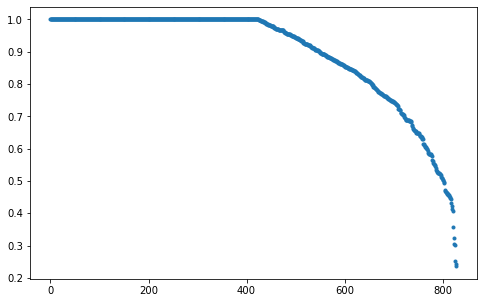

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(len(df_h2)), df_h2['h2'], ls='', marker='.')